- [ ] Interpret each insight
- [ ] Write wrangle_report
- [ ] Write act_report

In [1]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from fbprophet import Prophet

%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('analysis_data_set.csv', dtype={'tweet_id': 'object'})

In [3]:
df['created_at'] = pd.to_datetime(df.created_at)

In [4]:
df.describe()

,character_count,rating_ratio,favorite_count,retweet_count
count,1953.000000,1953.000000,1953.000000,1953.000000
mean,111.822837,1.164863,8908.530978,2761.408090
std,26.231909,4.106254,12212.221822,4638.821601
min,13.000000,0.000000,81.000000,16.000000
25%,94.000000,1.000000,1985.000000,629.000000
50%,116.000000,1.100000,4134.000000,1366.000000
75%,137.000000,1.200000,11394.000000,3238.000000
max,148.000000,177.600000,132810.000000,79515.000000


In [5]:
'''Will remove both 177.6 and 42.0 from ratings as they are more 
than two standard deviations from the mean, and I believe that 
they were given based on the dates July 4th, and April 20th 
rather than as a genuine rating'''

max_rating = df.rating_ratio.sort_values(ascending=False)[:2].to_list()

df = df.query('rating_ratio not in @max_rating')

### Top Breeds

In [6]:
# breed count

breed_count = df.query('dog == True')\
.groupby('breed').count()[['tweet_id']]\
.sort_values('tweet_id', ascending=False)[:20]


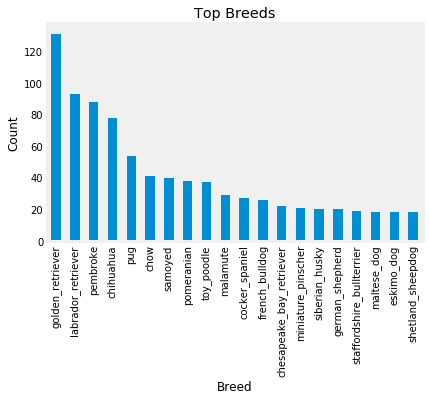

In [32]:
breed_count.plot(kind='bar', legend=False)
plt.title("Top Breeds")
plt.xlabel("Breed")
plt.ylabel("Count")
plt.grid();

In [8]:
# average likes and retweets of top dogs

avg_likes_retweets = df.query('dog == True').groupby('breed').mean()[['favorite_count', 'retweet_count']]
avg_likes_retweets['count'] = df.query('dog == True').groupby('breed').count()[['tweet_id']]

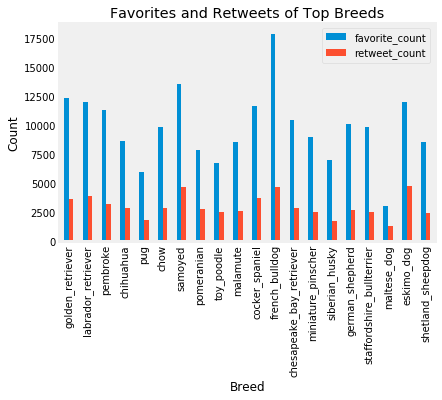

In [31]:
avg_likes_retweets.sort_values('count', ascending=False)[['favorite_count', 'retweet_count']][:20]\
.plot(kind='bar')
plt.title('Favorites and Retweets of Top Breeds')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.grid();

### Wordcloud Dog vs. Not Dog

In [10]:
# word cloud dog vs not 

dog = " ".join(tweet for tweet in df.query('dog == True').text)
not_dog = " ".join(tweet for tweet in df.query('dog == False').text)

stopwords = set(STOPWORDS)
stopwords.update(['https', 'co', 'ckin', 'meet', 'say', 'hello', 'ck', 'dog'])

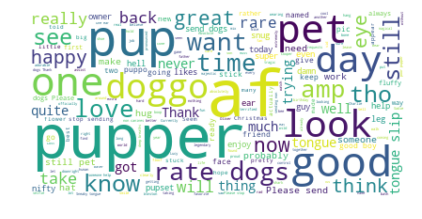

In [11]:
# dog word cloud

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(dog)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

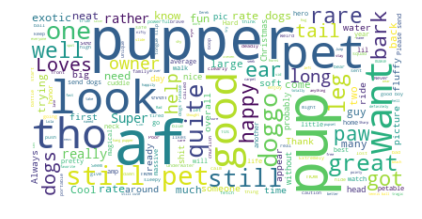

In [12]:
# not dog word cloud

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(not_dog)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

While using the image classification to determine if dog or not seemed like a good idea - the word cloud indicates that there are still dogs where they were classified as not dogs.

In [13]:
df.query('dog == False').groupby('breed').count()[['tweet_id']]\
.sort_values('tweet_id', ascending=False)[:5]

,tweet_id
breed,
seat_belt,21
teddy,17
web_site,14
dingo,8
tennis_ball,8


In [14]:
# reviewing images for the top dog=False breed - seat_belt.

df.query('breed == "seat_belt"').sample(3)

,tweet_id,created_at,source,text,character_count,name,dog,breed,dogtionary,rating_ratio,favorite_count,retweet_count,expanded_urls,jpg_url
502,785170936622350336,2016-10-09 17:31:53,Twitter iPhone,This is Hero. He was enjoying the car ride unt...,118,Hero,False,seat_belt,NaN,1.1,13491,5639,https://twitter.com/dog_rates/status/785170936...,https://pbs.twimg.com/media/CuV8yfxXEAAUlye.jpg
1759,669625907762618368,2015-11-25 21:17:12,Twitter iPhone,This is Penny. She's having fun AND being safe...,98,Penny,False,seat_belt,NaN,1.2,3769,1963,https://twitter.com/dog_rates/status/669625907...,https://pbs.twimg.com/media/CUr9NjgU8AEpf5w.jpg
654,757725642876129280,2016-07-25 23:54:05,Twitter iPhone,This is Beckham. He fell asleep at the wheel. ...,115,Beckham,False,seat_belt,NaN,1.1,5022,1391,https://twitter.com/dog_rates/status/757725642...,https://pbs.twimg.com/media/CoP7c4bWcAAr55g.jpg


### Forcast favorite_retweet_ratio

In [15]:
# Group by month 
df_day = df.copy()

date_fmt = pd.to_datetime(df_day.created_at).dt.strftime('%Y-%m')
df_day['created_at'] = pd.to_datetime(date_fmt)

forcast = df_day.groupby('created_at').mean()[:-1]

In [16]:
# create retweet:favorite ratio, and the tweet count column

forcast['favorite_retweet_ratio'] = forcast.retweet_count / forcast.favorite_count
forcast['tweet_count'] = df_day.groupby('created_at').count()['tweet_id']

forcast

,character_count,dog,rating_ratio,favorite_count,retweet_count,favorite_retweet_ratio,tweet_count
created_at,,,,,,,
2015-11-01,123.160959,0.650685,0.888699,1222.883562,531.678082,0.434774,292
2015-12-01,115.533520,0.670391,0.955659,3530.756983,1523.589385,0.431519,358
2016-01-01,117.927273,0.745455,1.007879,4000.551515,1524.363636,0.381038,165
2016-02-01,117.092593,0.759259,1.012037,4308.157407,1609.111111,0.373503,108
2016-03-01,118.084746,0.771186,1.038136,4638.567797,1650.754237,0.355876,118
2016-04-01,105.888889,0.833333,1.037037,4703.851852,1613.203704,0.342954,54
2016-05-01,87.290909,0.709091,1.085455,5400.781818,1902.618182,0.352286,55
2016-06-01,98.743590,0.769231,1.025641,9510.076923,4144.794872,0.435832,78
2016-07-01,94.464286,0.773810,1.088095,7075.916667,2519.428571,0.356057,84


In [17]:
forcast.describe()

,character_count,dog,rating_ratio,favorite_count,retweet_count,favorite_retweet_ratio,tweet_count
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,108.813449,0.777973,1.125259,13430.069980,3860.327513,0.326412,92.809524
std,12.351841,0.060847,0.113226,9371.487745,2108.156613,0.067753,83.440170
min,87.290909,0.650685,0.888699,1222.883562,531.678082,0.215983,38.000000
25%,99.655172,0.758621,1.037037,4703.851852,1650.754237,0.260683,51.000000
50%,115.533520,0.771186,1.119476,11435.476190,4144.794872,0.331245,63.000000
75%,118.000000,0.812500,1.223684,19863.769231,5527.673077,0.356057,84.000000
max,126.026316,0.897959,1.280612,31801.183673,7570.023810,0.435832,358.000000


In [22]:
corr = forcast.loc[:].corr()
corr

,character_count,dog,rating_ratio,favorite_count,retweet_count,favorite_retweet_ratio,tweet_count
character_count,1.000000,-0.063564,0.014985,0.266970,0.073335,-0.292185,0.288878
dog,-0.063564,1.000000,0.671997,0.629971,0.610185,-0.641685,-0.682183
rating_ratio,0.014985,0.671997,1.000000,0.925848,0.924414,-0.894166,-0.742797
favorite_count,0.266970,0.629971,0.925848,1.000000,0.954989,-0.865546,-0.566762
retweet_count,0.073335,0.610185,0.924414,0.954989,1.000000,-0.740540,-0.612038
favorite_retweet_ratio,-0.292185,-0.641685,-0.894166,-0.865546,-0.740540,1.000000,0.663790
tweet_count,0.288878,-0.682183,-0.742797,-0.566762,-0.612038,0.663790,1.000000


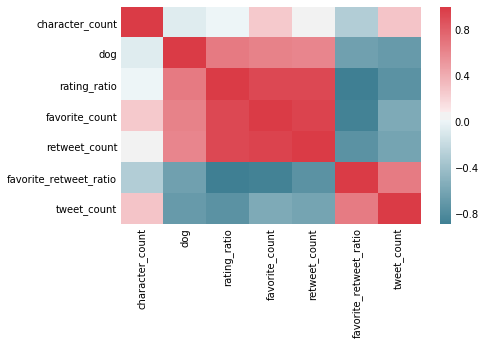

In [23]:
# visualizing the correlation matrix above, we can quickly see where the strongest correlations are

sns.heatmap(corr, xticklabels=corr.columns, 
            yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True));

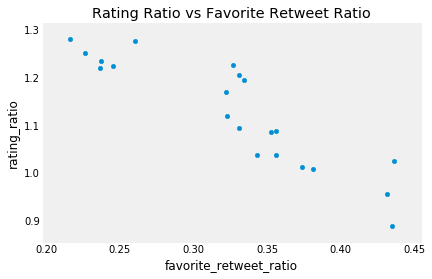

In [40]:
forcast[['favorite_retweet_ratio', 'rating_ratio']]\
.plot(kind='scatter', y='rating_ratio', x='favorite_retweet_ratio')
plt.title("Rating Ratio vs Favorite Retweet Ratio")
plt.grid();

Tweets with higher rating ratios correlate with a lower favorite_retweet_ratio.  Here we can visualize this strong negative correlation.

## Forcast something with a trend

In [43]:
forcast[['rating_ratio']].head(1)

,rating_ratio
created_at,
2015-11-01,0.888699


In [120]:
data = forcast[['rating_ratio']].reset_index().rename(columns={'created_at': 'ds', 'rating_ratio': 'y'})

In [133]:
tm = Prophet(seasonality_mode='multiplicative', 
             growth='linear',
             yearly_seasonality=True,
             weekly_seasonality=False,
             daily_seasonality=False,
             n_changepoints=6, 
             interval_width=0.95
            ).fit(data)

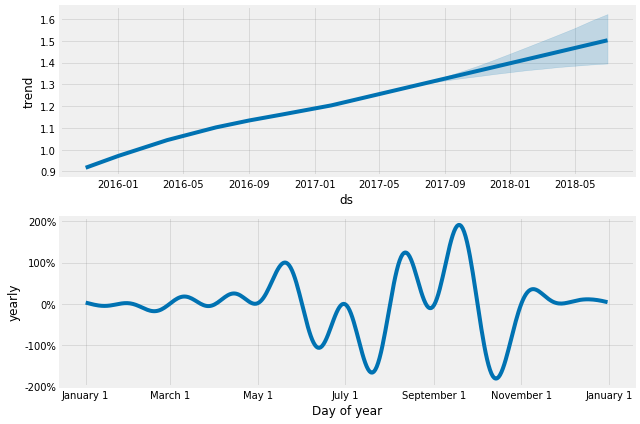

In [134]:
future = tm.make_future_dataframe(periods=12, freq='MS')
rating_forcast = tm.predict(future)

tm.plot_components(rating_forcast);

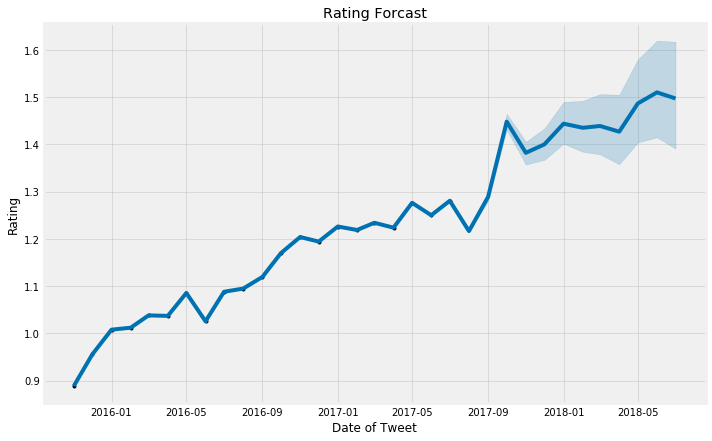

In [135]:
tm.plot(rating_forcast, xlabel='Date of Tweet', ylabel='Rating')
plt.title("Rating Forcast");